<a href="https://colab.research.google.com/github/ieliasbar/Parkinson_classification/blob/master/parkinson_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONTEXT

Images of healthy and patients with Parkinsons drawing spirals and waves. The images are further divided into training and testing groups for comparing (or reproducing) the results of the original publication.

The data came from the paper: Zham P, Kumar DK, Dabnichki P, Poosapadi Arjunan S and Raghav S (2017) Distinguishing Different Stages of Parkinson’s Disease Using Composite Index of Speed and Pen-Pressure of Sketching a Spiral. Front. Neurol. 8:435. doi: 10.3389/fneur.2017.00435

#ACKNOWLEDGEMENTS

Source: https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet

Citation:

1.Isenkul, M.E.; Sakar, B.E.; Kursun, O. . 'Improved spiral test using digitized graphics tablet for monitoring Parkinson's disease.' The 2nd International Conference on e-Health and Telemedicine (ICEHTM-2014), pp. 171-175, 2014.

2.Erdogdu Sakar, B., Isenkul, M., Sakar, C.O., Sertbas, A., Gurgen, F., Delil, S., Apaydin, H., Kursun, O., 'Collection and Analysis of a Parkinson Speech Dataset with Multiple Types of Sound Recordings', IEEE Journal of Biomedical and Health Informatics, vol. 17(4), pp. 828-834, 2013.

#IMPORT LIBRARIES

In [1]:
!pip install tensorflow-gpu==2.0.0.alpha0

     |████████████████████████████████| 332.1MB 41kB/s 
     |████████████████████████████████| 3.0MB 41.2MB/s 
     |████████████████████████████████| 419kB 56.3MB/s 


In [2]:
import tensorflow as tf
tf.__version__

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

'2.0.0-alpha0'

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from tensorflow.keras import models, layers
import cv2

# IMPORT DATASET: SPIRAL

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spiral_training = '/content/drive/My Drive/Colab Notebooks/Kaggle/Parkinson_classification/spiral/training/'
spiral_testing = '/content/drive/My Drive/Colab Notebooks/Kaggle/Parkinson_classification/spiral/testing/'
batch_size = 24

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
spiral_datagen = ImageDataGenerator(rescale=1./255, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range = 360, horizontal_flip=True, vertical_flip=True)

In [0]:
# Equalize the image
from skimage import exposure

def eqz_plz(img):
    return exposure.equalize_hist(img)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = equalize(img)
    img = img.astype('float32') / 255.
    return img

In [8]:
train_gen_spiral = spiral_datagen.flow_from_directory(directory=os.path.abspath(spiral_training),target_size = (256, 256),
                                                      color_mode = 'grayscale',batch_size = batch_size,
                                                      class_mode = 'binary',shuffle = True)
test_gen_spiral = spiral_datagen.flow_from_directory(directory=os.path.abspath(spiral_testing),target_size = (256, 256),
                                                     color_mode = 'grayscale',batch_size = batch_size,
                                                     class_mode = 'binary',shuffle = True)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [9]:
classes_df_spiral = pd.DataFrame(train_gen_spiral.classes)
classes_df_spiral.columns=['Classes']
classes_df_spiral.head()

,Classes
0,0
1,0
2,0
3,0
4,0


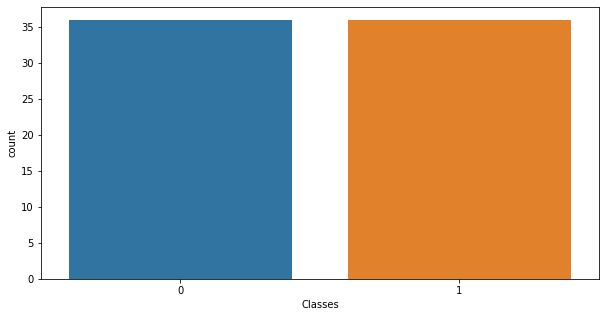

In [10]:
plt.figure(figsize=(10, 5))
classes_df_spiral['Classes'].value_counts()
sns.countplot(classes_df_spiral.iloc[:,0])

#VISUALIZE IMAGES: SPIRAL

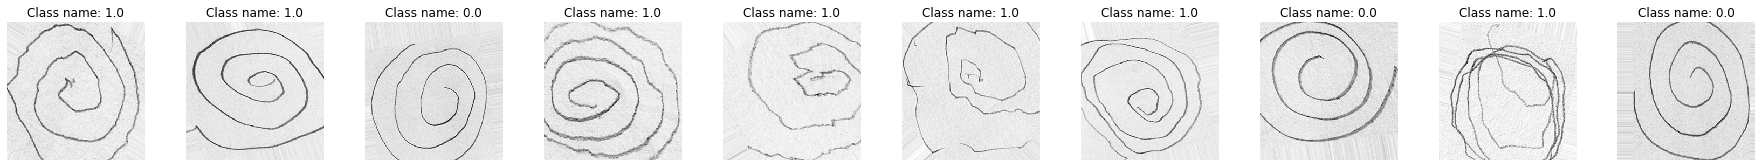

In [11]:
X_batch, y_batch = next(train_gen_spiral)
fig, axes = plt.subplots(1,10, figsize = (25,25))
fig.tight_layout()

for i in range(10):
  axes[i].imshow(X_batch[i].reshape(256,256), cmap=plt.get_cmap("gray"))
  axes[i].set_title('Class name: {}'.format(y_batch[i]))
  axes[i].axis('off')

#CREATE MODEL

In [0]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(256, (5,5), input_shape = (256,256,1), activation = 'elu', padding='same',kernel_initializer='glorot_normal'))
    model.add(layers.Conv2D(150,(5,5), activation='elu', kernel_initializer='glorot_normal'))
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    model.add(layers.Conv2D(128, (5,5), activation='elu', padding='same',kernel_initializer='glorot_normal'))
    model.add(layers.MaxPooling2D(pool_size=(3,3)))
    model.add(layers.Conv2D(64, (5,5), activation='elu', padding='same',kernel_initializer='glorot_normal'))
    model.add(layers.MaxPooling2D(pool_size=(3,3)))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(512, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer = Adam(lr=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
model = cnn_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 256)     6656      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 150)     960150    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 150)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 128)     480128    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        204864    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0

#TRAINING THE MODEL: SPIRAL


In [14]:
epochs_hist_spiral = model.fit_generator(train_gen_spiral, epochs = 40, steps_per_epoch=(3500//batch_size), validation_data=test_gen_spiral, validation_steps=(1500//batch_size), verbose=1)

Epoch 1/40
145/145 [==============================] - 150s 1s/step - loss: 0.6933 - accuracy: 0.4989 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/40
145/145 [==============================] - 119s 818ms/step - loss: 0.6931 - accuracy: 0.5057 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 3/40
145/145 [==============================] - 119s 818ms/step - loss: 0.6926 - accuracy: 0.5098 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 4/40
145/145 [==============================] - 119s 820ms/step - loss: 0.6910 - accuracy: 0.5371 - val_loss: 0.6890 - val_accuracy: 0.5774
Epoch 5/40
145/145 [==============================] - 119s 817ms/step - loss: 0.6848 - accuracy: 0.5560 - val_loss: 0.6933 - val_accuracy: 0.5022
Epoch 6/40
145/145 [==============================] - 119s 818ms/step - loss: 0.6701 - accuracy: 0.6052 - val_loss: 0.6883 - val_accuracy: 0.5398
Epoch 7/40
145/145 [==============================] - 119s 817ms/step - loss: 0.6387 - accuracy: 0.6483 - val_loss: 0.6396 - va

In [17]:
score_spiral = model.evaluate(test_gen_spiral)
print('Test Accuracy (Spiral): {}'.format(score_spiral[1]))

2/2 [==============================] - 0s 178ms/step - loss: 0.6210 - accuracy: 0.7667
Test Accuracy (Spiral): 0.7666666507720947


#RESULTS: SPIRAL

In [0]:
accuracy_spiral = epochs_hist_spiral.history['accuracy']
val_accuracy_spiral = epochs_hist_spiral.history['val_accuracy']
loss_spiral = epochs_hist_spiral.history['loss']
val_loss_spiral = epochs_hist_spiral.history['val_loss']

In [0]:
epochs = range(len(accuracy_spiral))

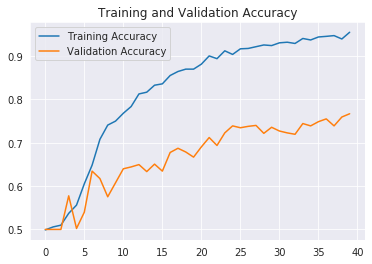

In [20]:
sns.set_style('darkgrid')
plt.plot(accuracy_spiral, label='Training Accuracy')
plt.plot(val_accuracy_spiral, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

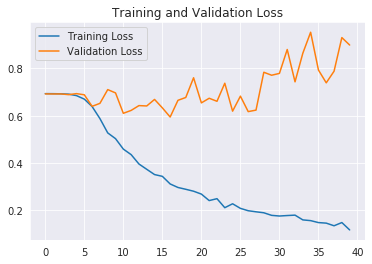

In [21]:
sns.set_style('darkgrid')
plt.plot(loss_spiral, label='Training Loss')
plt.plot(val_loss_spiral, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

Using some data for testing

In [0]:
X_test_spiral, y_test_spiral = next(test_gen_spiral)

In [0]:
predicted_classes_spiral = model.predict_classes(X_test_spiral)
y_true_spiral = y_test_spiral

Confusion Matrix for test data

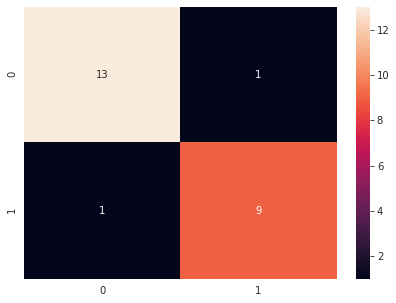

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_spiral, predicted_classes_spiral)
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True)



1.   Parkinson: Label 1
2.   Healthy: Label 0



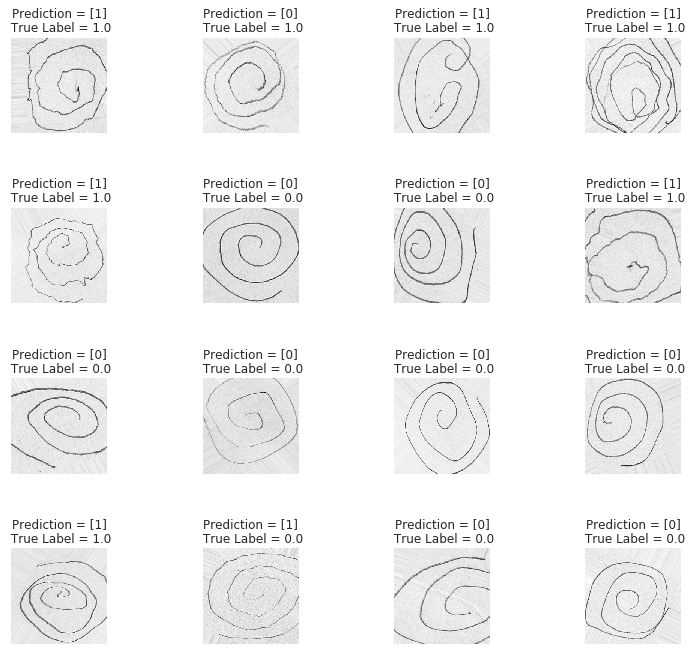

In [25]:
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test_spiral[i].reshape(256,256), cmap=plt.get_cmap("gray"))
    axes[i].set_title('Prediction = {}\n True Label = {}'.format(predicted_classes_spiral[i], y_true_spiral[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

# IMPORT DATASET: WAVE

In [0]:
wave_training = '/content/drive/My Drive/Colab Notebooks/Kaggle/Parkinson_classification/wave/training/'
wave_testing = '/content/drive/My Drive/Colab Notebooks/Kaggle/Parkinson_classification/wave/testing/'
batch_size = 24

In [0]:
wave_datagen = ImageDataGenerator(rescale=1./255, width_shift_range = 0.1, height_shift_range = 0.1, zoom_range = 0.2, shear_range = 0.1, rotation_range = 360, horizontal_flip=True, vertical_flip=True)

In [28]:
train_gen_wave = wave_datagen.flow_from_directory(directory=os.path.abspath(wave_training),target_size = (256, 256),
                                                      color_mode = 'grayscale',batch_size = batch_size,
                                                      class_mode = 'binary',shuffle = True)
test_gen_wave = wave_datagen.flow_from_directory(directory=os.path.abspath(wave_testing),target_size = (256, 256),
                                                     color_mode = 'grayscale',batch_size = batch_size,
                                                     class_mode = 'binary',shuffle = True)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [29]:
classes_df_wave = pd.DataFrame(train_gen_wave.classes)
classes_df_wave.columns=['Classes_wave']
classes_df_wave.head()

,Classes_wave
0,0
1,0
2,0
3,0
4,0


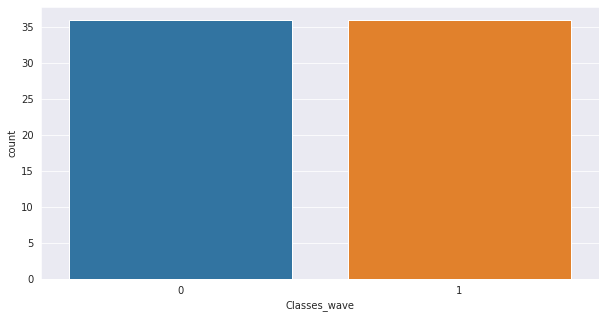

In [30]:
plt.figure(figsize=(10, 5))
classes_df_wave['Classes_wave'].value_counts()
sns.countplot(classes_df_wave.iloc[:,0])

#VISUALIZE IMAGES: WAVE

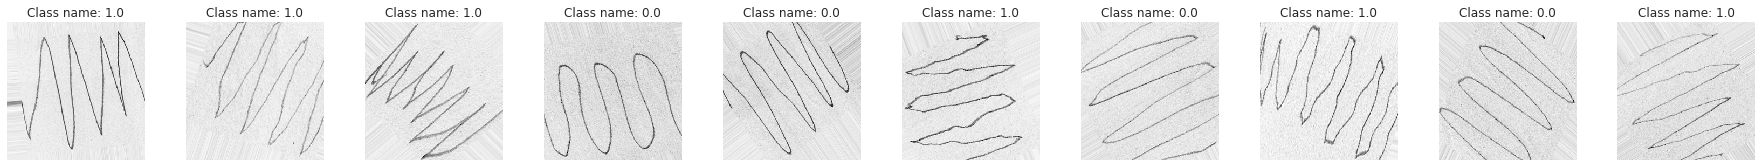

In [31]:
X_batch, y_batch = next(train_gen_wave)
fig, axes = plt.subplots(1,10, figsize = (25,25))
fig.tight_layout()

for i in range(10):
  axes[i].imshow(X_batch[i].reshape(256,256), cmap=plt.get_cmap("gray"))
  axes[i].set_title('Class name: {}'.format(y_batch[i]))
  axes[i].axis('off')

# TRAINING THE MODEL: WAVE

In [32]:
epochs_hist_wave = model.fit_generator(train_gen_wave, epochs = 40, steps_per_epoch=(3000//batch_size), validation_data=test_gen_wave, validation_steps=(1000//batch_size), verbose=1)

Epoch 1/40
125/125 [==============================] - 130s 1s/step - loss: 0.7303 - accuracy: 0.6547 - val_loss: 0.6986 - val_accuracy: 0.5929
Epoch 2/40
125/125 [==============================] - 102s 819ms/step - loss: 0.5438 - accuracy: 0.7320 - val_loss: 0.7123 - val_accuracy: 0.6202
Epoch 3/40
125/125 [==============================] - 102s 818ms/step - loss: 0.5159 - accuracy: 0.7563 - val_loss: 0.7625 - val_accuracy: 0.6106
Epoch 4/40
125/125 [==============================] - 102s 818ms/step - loss: 0.4949 - accuracy: 0.7670 - val_loss: 0.6274 - val_accuracy: 0.6538
Epoch 5/40
125/125 [==============================] - 102s 819ms/step - loss: 0.4667 - accuracy: 0.7850 - val_loss: 0.6712 - val_accuracy: 0.6635
Epoch 6/40
125/125 [==============================] - 102s 820ms/step - loss: 0.4540 - accuracy: 0.7843 - val_loss: 0.6920 - val_accuracy: 0.6619
Epoch 7/40
125/125 [==============================] - 102s 819ms/step - loss: 0.4275 - accuracy: 0.8097 - val_loss: 0.7340 - va

In [36]:
score_wave = model.evaluate(test_gen_wave)
print('Test Accuracy (Wave): {:.2f}'.format(score_wave[1]))

2/2 [==============================] - 0s 196ms/step - loss: 1.1750 - accuracy: 0.8333
Test Accuracy (Wave): 0.83


#RESULTS: WAVE

In [0]:
accuracy_wave = epochs_hist_wave.history['accuracy']
val_accuracy_wave = epochs_hist_wave.history['val_accuracy']
loss_wave = epochs_hist_wave.history['loss']
val_loss_wave = epochs_hist_wave.history['val_loss']

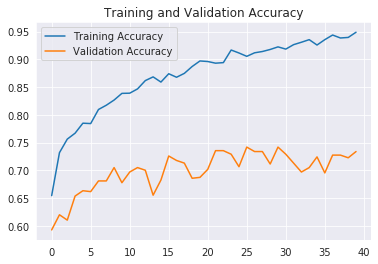

In [38]:
sns.set_style('darkgrid')
plt.plot(accuracy_wave, label='Training Accuracy')
plt.plot(val_accuracy_wave, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

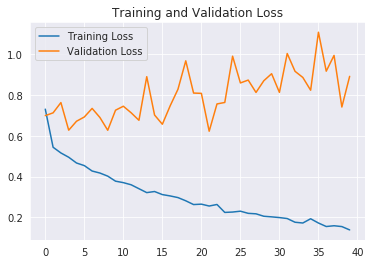

In [39]:
sns.set_style('darkgrid')
plt.plot(loss_wave, label='Training Loss')
plt.plot(val_loss_wave, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

Using some data for testing

In [0]:
X_test_wave, y_test_wave = next(test_gen_wave)

In [0]:
predicted_classes_wave = model.predict_classes(X_test_wave)
y_true_wave = y_test_wave

Confusion Matrix for test data

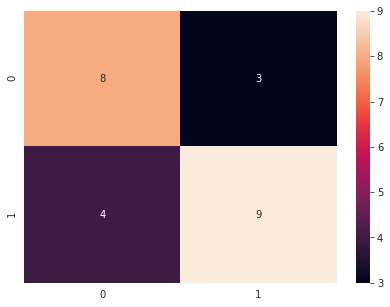

In [42]:
cm = confusion_matrix(y_true_wave, predicted_classes_wave)
plt.figure(figsize = (7, 5))
sns.heatmap(cm, annot = True)



*   Parkinson: Label 1
*   Healthy: Label 0



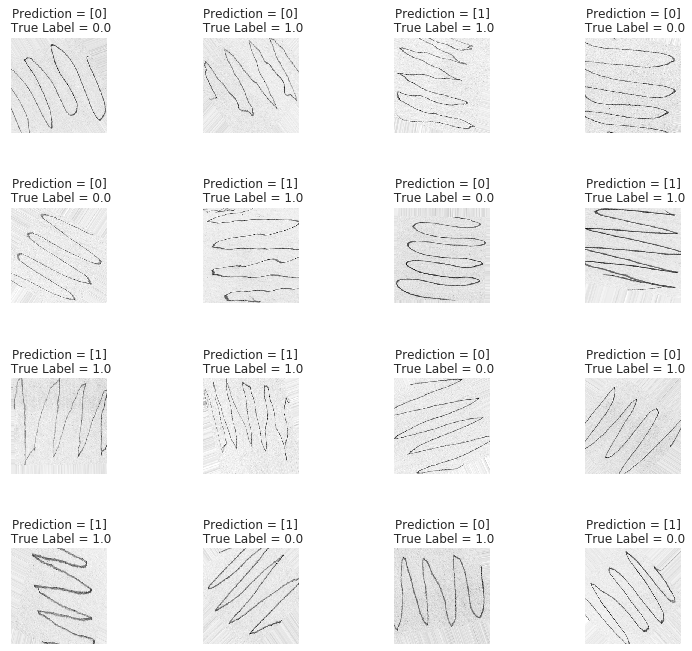

In [43]:
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test_wave[i].reshape(256,256), cmap=plt.get_cmap("gray"))
    axes[i].set_title('Prediction = {}\n True Label = {}'.format(predicted_classes_wave[i], y_true_wave[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)